In [1]:
from typing import Callable, Union
from tensorflow.keras import backend as K
import tensorflow as tf

# https://github.com/maxvfischer/keras-image-segmentation-loss-functions/blob/master/losses/multiclass_losses.py
def multiclass_weighted_cross_entropy(
    class_weights: list, is_logits: bool = False
) -> Callable[[tf.Tensor, tf.Tensor], tf.Tensor]:
    """
    Multi-class weighted cross entropy.
        WCE(p, p̂) = −Σp*log(p̂)*class_weights
    Used as loss function for multi-class image segmentation with one-hot encoded masks.
    :param class_weights: Weight coefficients (list of floats)
    :param is_logits: If y_pred are logits (bool)
    :return: Weighted cross entropy loss function (Callable[[tf.Tensor, tf.Tensor], tf.Tensor])
    """
    if not isinstance(class_weights, tf.Tensor):
        class_weights = tf.constant(class_weights)

    def loss(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
        """
        Computes the weighted cross entropy.
        :param y_true: Ground truth (tf.Tensor, shape=(None, None, None, None))
        :param y_pred: Predictions (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, <N_CLASSES>))
        :return: Weighted cross entropy (tf.Tensor, shape=(<BATCH_SIZE>,))
        """
        assert len(class_weights) == y_pred.shape[-1], (
            f"Number of class_weights ({len(class_weights)}) needs to be the same as number "
            f"of classes ({y_pred.shape[-1]})"
        )

        if is_logits:
            y_pred = softmax(y_pred, axis=-1)

        y_pred = K.clip(
            y_pred, K.epsilon(), 1 - K.epsilon()
        )  # To avoid unwanted behaviour in K.log(y_pred)

        # p * log(p̂) * class_weights
        wce_loss = y_true * K.log(y_pred) * class_weights

        # Average over each data point/image in batch
        axis_to_reduce = range(1, K.ndim(wce_loss))
        wce_loss = K.mean(wce_loss, axis=axis_to_reduce)

        return -wce_loss

    return loss


2022-11-20 22:37:05.260640: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-20 22:37:05.430599: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-20 22:37:06.192880: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-20 22:37:06.192983: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
import os

best_model = tf.keras.models.load_model(
    "model",
    custom_objects={"loss": multiclass_weighted_cross_entropy([10.0, 100.0, 100.0])},
)
best_model.summary()

2022-11-20 22:37:07.210644: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:42:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-20 22:37:07.221621: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:42:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-20 22:37:07.222118: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:42:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-20 22:37:07.223516: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, widgets
from tqdm import tqdm

TEST_DATA_DIR = os.path.join(os.curdir, "dataset", "test")


def get_filenames(index):
    return [
        os.path.join(TEST_DATA_DIR, filename)
        for filename in sorted(os.listdir(TEST_DATA_DIR))
        if int(filename.split("_")[1]) == index
    ]


def get_images_and_predictions(index):
    images = []
    predictions = []
    filenames = get_filenames(index)
    for filename in tqdm(filenames):
        with open(filename, "rb") as f:
            image = np.load(f)
            images.append(image)
            prediction = best_model.predict(image[np.newaxis, ...], verbose=0)
            prediction = prediction.squeeze().argmax(axis=-1)
            predictions.append(prediction)
    return images, predictions


images30, predictions30 = get_images_and_predictions(30)
images40, predictions40 = get_images_and_predictions(40)
images50, predictions50 = get_images_and_predictions(50)
print(len(images30))
print(images30[0].shape)
print(len(predictions30))
print(predictions30[0].shape)


  0%|          | 0/124 [00:00<?, ?it/s]2022-11-20 22:37:13.679825: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2022-11-20 22:37:14.593174: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
100%|██████████| 86/86 [00:08<00:00, 10.47it/s]

124
(256, 256)
124
(256, 256)


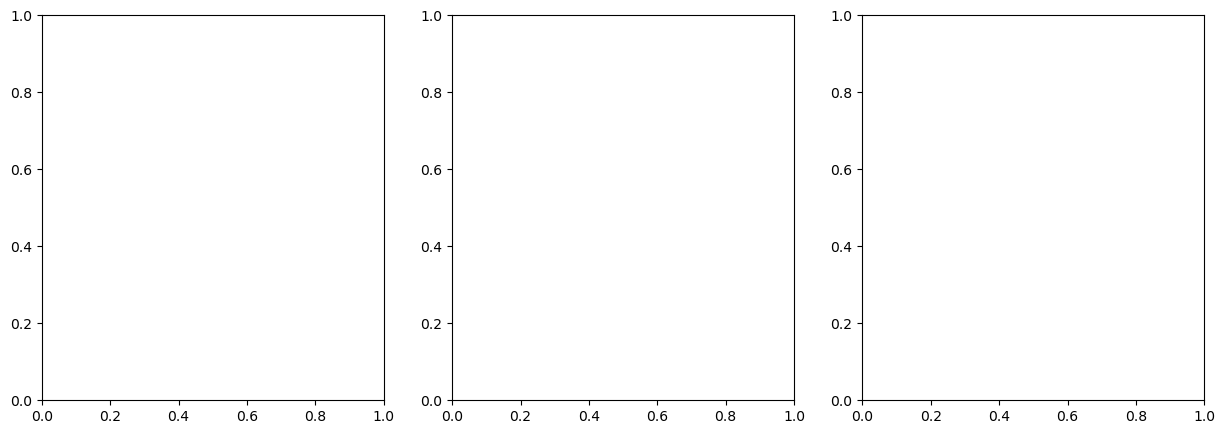

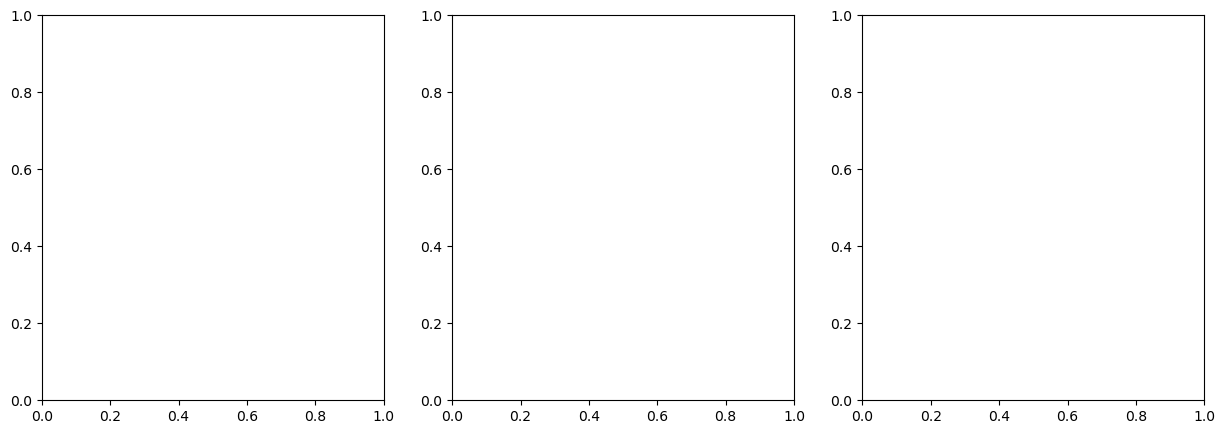

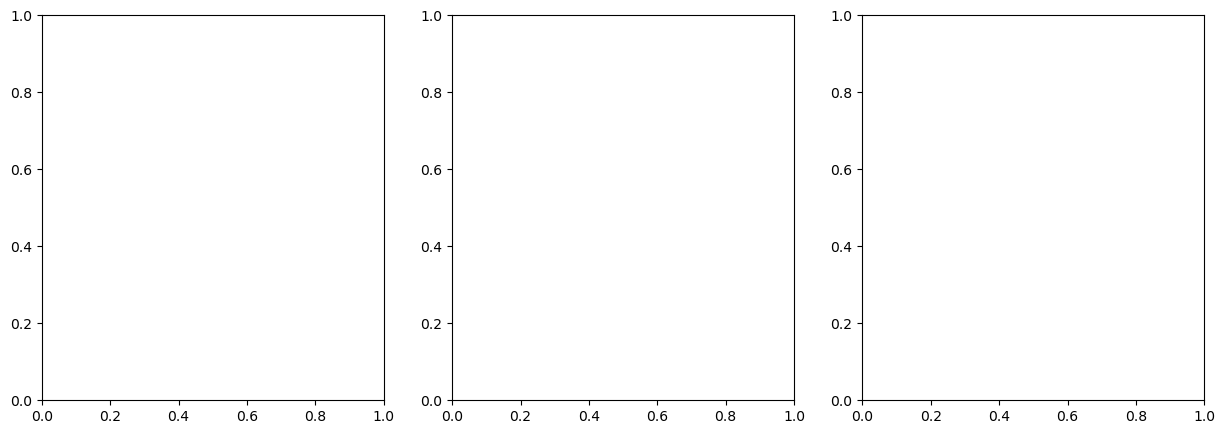

In [4]:
fig30, axs30 = plt.subplots(1, 3, figsize=(15, 5))
fig40, axs40 = plt.subplots(1, 3, figsize=(15, 5))
fig50, axs50 = plt.subplots(1, 3, figsize=(15, 5))

In [5]:
def show(images, predictions, fig, axs, title):
    fig.suptitle(title)
    axs[0].set_title("Data")
    axs[2].set_title("Label")
    def frame30(x):
        index = int(x)
        axs[0].imshow(images[index])
        axs[1].clear()
        axs[1].imshow(images[index], alpha=0.5)
        axs[1].imshow(predictions[index], alpha=0.5, cmap="hot")
        axs[2].imshow(predictions[index], cmap="hot")
        display(fig)
    interact(frame30, x=widgets.IntSlider(min=0, max=len(images)-1, step=1, value=40))

show(images30, predictions30, fig30, axs30, "HFH 30")


interactive(children=(IntSlider(value=40, description='x', max=123), Output()), _dom_classes=('widget-interact…

In [6]:
show(images40, predictions40, fig40, axs40, "HFH 40")

interactive(children=(IntSlider(value=40, description='x', max=107), Output()), _dom_classes=('widget-interact…

In [7]:

show(images50, predictions50, fig50, axs50, "HFH 50")


interactive(children=(IntSlider(value=40, description='x', max=85), Output()), _dom_classes=('widget-interact'…